## Table of Contents
-   [ Notes](#1)
-   [ Required Packages](#2)
- [1 - PREPARE FOR PROCESSING](#preProcess)
- [2 - Calibrate values for the batch](#calibrate)
- [3 - Determine horizontal board disposition](#disposition)
- [4 - Identify and split boards sections.](#split)
- [5 - Validate Model and Label topBoards.](#validate)
- [4 - Identify and split boards sections.](#split)

    - [Exercise 3 - initialize_velocity](#ex-3)
    - [Exercise 4 - update_parameters_with_momentum](#ex-4)


<a name='1'></a>
# Notes from the Candidate.

<p><font  face="Times New Roman" size ='5'> <font color='grey' > 
<br> I have decided to follow a different process for this exercise. I will be following a format as I was logging my findings and sharing my thoughts and/or conclusions at the end of each. I hope you find this change interesting.
<font  face="Times New Roman" size ='3'> <font color='grey' > 
<br>
Although, I believe at the time I'm writing this, that gradient detectors applied on the area will probably be the best solution.
</p>

# CameraBottom Assignment

Please find now the attached images of baseboards with superficial scratches. They look like cracks but they are not. 
*	Detect them (binarize). 
*	How could we distinguish from the previous cracks? Note that a crack makes the element be defective and a scratch makes it not. 
*	Images and scratches location in pixels:
    *	B58 BB1, right vertical element in the image, in its central part [approx. 1820x927].
    *	D59 BB2, BB5 and BB4, horizontal elements in the image, in its central part [approx. 1078x440, 1037x1088, 1000x1622].
*	Please note that first we need to emphasize them and then to detect that the element has a crack, binarizing the split.
*	Images and cracks location in pixels:
    *	B78 BB5, central horizontal element in the image, in its central part [approx. 800x920].
    *	D82 BB3, left vertical element in the image [approx. 274x1300 and along its vertical axis].
    *	D83 BB3, left vertical element in the image [approx. 318x697 and along its vertical axis].
    *	E24 BB4, lower horizontal element in la image [approx., 665x1614].
    *	E56 BB5, central horizontal element in the image, at its left part [approx. 540x1000].
    *   E70 BB1, right vertical element in the image, in its lower part [approx. 1730x1440].



<br>



###  <font color='default' > Notes on the project.

<p><font  face="Times New Roman"> <font color='grey' > The project is fairly straight forward. We are asked to differentiate scratches and real damage present in the boards. For that purpose, we are actuallt given the regions of interest to be investigated, so we will be skipping the localization part.

<br>To know what is a scratch and what might be damage, we at least must know what one them actually is. So my approach will imply separating the sets into learning sets (for both scratches and damage) and then a test set containing a mix of both of them. I will avoid overlapping learning and test sets so we could (moreless) conclude that the process works. This is a setup common for Deep learning projects, and I can't help but wonder how a DL solution will do in this scenario with enought data.
</p>



<a name='2'></a>
## - Packages and Globals

We load known packages to be used in this demostration and define some global variables.

In [64]:


import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import SupportFunctions as mySF
from sklearn.cluster import KMeans
from collections import namedtuple

# path to the images
TOP_IMAGES_PATH = "./camera_top"
GREY_CALIB_IMAGES_PATH = "./greyLevelCalib"


BOTTOM_IMAGES_PATH = "./camera_bottom/"


scratch_label = 100
crack_label = 101

# areas of interest for each image
area_B58_scratch = [BOTTOM_IMAGES_PATH+"B58.tif", [[1820,927]]]  #  [1780,927]
area_D59_scratch = [BOTTOM_IMAGES_PATH+"B59.tif",[[1078,440], [1037,1088], [1000,1622]] ]

area_B78_crack  = [BOTTOM_IMAGES_PATH+"B78.tif",[[800,980    ]]]  # [800,920    ]]
area_D82_crack  = [BOTTOM_IMAGES_PATH+"D82.tif",[[274,1300   ]]]
area_D83_crack  = [BOTTOM_IMAGES_PATH+"D83.tif",[[318,697    ]]]
area_E24_crack  = [BOTTOM_IMAGES_PATH+"E24.tif",[[665,1614   ]]]
area_E56_crack  = [BOTTOM_IMAGES_PATH+"E56.tif",[[540,1000   ]]]
area_E70_crack  = [BOTTOM_IMAGES_PATH+"E70.tif",[[1730,1440  ]]]

training_scratch_list = [area_D59_scratch]
training_crack_list = [area_B78_crack,area_D82_crack,area_E24_crack]
# image + labels,... there is an issue here, not knowing which is which in case of crack and scratches in the same board
multiAreaList = [area_D59_scratch,area_B78_crack]
test_list = [area_D83_crack,area_E56_crack,area_E70_crack,area_B58_scratch]
# test_list = [[area_D83_crack,[crack_label]],[area_E56_crack,[crack_label]],[area_E70_crack,[crack_label]],[area_B58_scratch,[scratch_label]]]



<a name='preProcess'></a>
## PREPARE FOR PROCESSING


Taken from 'Top Boards' exercise

This step implies going from a Uint16 matrix to a one that will be more managable, and the image will be ready for the cleanest and fastest extraction of information.


### Possible steps to take:
<a name='ex-1'></a>
* Verify the board alignment. If the board is somehow angled, we must find out and correct it.
<b>Seems to have been corrected already</b>, so we will skip it for the time being). This will be validated when we observe the histograms in the upcomming steps. 
<br></br>


* For the topBoard check does not seem necessary to keep al the bit information of the uint16 matrix we have.
The regular uint8 should speed up the calculations without missing on information. Again, when detecting scratch and or other damage, this information will probably be much more handy.<br>Additionally, we will normallize the image to make the information more easily observable.<br><br>

* Prepare information regarding different boards, like width. Also, identify the spacing and disposition of elements regarding all 3 possible top-board variations. <br></br>


###  <font color='default' > Additional notes.

<p><font  face="Times New Roman"> <font color='grey' > I dived into this challenge unsure on how much the levels would be marked. My expectation is that the main difference between scratches and cracks, is that cracks are simple deeper. Meaning that these areas should be darker in terms of cracks. In any case, this section serves for my own observations and I will follow up with more conclusions afterwards.





<Figure size 432x288 with 0 Axes>

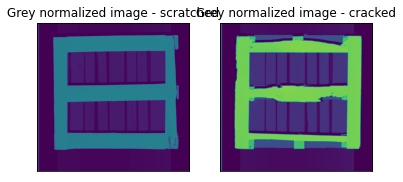

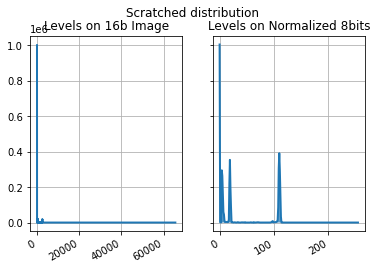

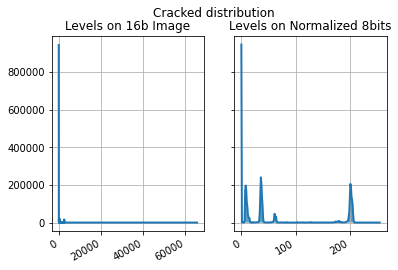

In [65]:

#   
def Convert8bAndNormalize ( image16b ):
    normalized = cv.normalize(image16b,None,0,65535,cv.NORM_MINMAX)
    return cv.convertScaleAbs(normalized,alpha=(255.0/65535.0))
    
def Convert8b (image16b):
    max_val = image16b.max()
    # return cv.convertScaleAbs(image16b,alpha=(255.0/max_val))
    return cv.convertScaleAbs(image16b,alpha=(255.0/65535.0))
    
def Normalize16b ( image16b ):
    return cv.normalize(image16b,None,0,65535,cv.NORM_MINMAX)

###############     execution part      ############

# sample scratch
scract_sample_filepath = area_B58_scratch[0]
scract_sample_location = area_B58_scratch[1][0]
scract_image16 = cv.imread(scract_sample_filepath, -1)

crack_sample_filepath = area_B78_crack[0]
crack_sample_location = area_B78_crack[1][0]
crack_image16 = cv.imread(crack_sample_filepath, -1)

scract_hist_values = cv.calcHist([scract_image16.flatten()],channels=[0],mask=None,histSize=[65535],ranges=[0,65535])
scract_image8bNorm = Convert8bAndNormalize ( scract_image16 )
scract_hist_values_norm = cv.calcHist([scract_image8bNorm.flatten()],channels=[0],mask=None,histSize=[256],ranges=[0,255])

crack_hist_values = cv.calcHist([crack_image16.flatten()],channels=[0],mask=None,histSize=[65535],ranges=[0,65535])
crack_image8bNorm = Convert8bAndNormalize ( crack_image16 )
crack_hist_values_norm = cv.calcHist([crack_image8bNorm.flatten()],channels=[0],mask=None,histSize=[256],ranges=[0,255])




#########  Show images and marked regions

fig = plt.figure (1)
# cosmeti display of information
# fig.set_figheight(1500)
# fig.set_figwidth(15)

fig, (ax0,ax1) = plt.subplots(1, 2)
# imageCOL = cv.drawContours(imageCOL, board, -1, (0, 255, 0),10)
ax0.get_yaxis().set_visible(False)
ax0.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax0.imshow(scract_image8bNorm)
ax0.set_title('Grey normalized image - scratched')
ax1.imshow(crack_image8bNorm)
ax1.set_title('Grey normalized image - cracked')


################# show scratch hist

fig1, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True)

ax2.fill_between(range(0,256), min(scract_hist_values_norm[:,0]),scract_hist_values_norm[:,0],alpha=0.7)
ax2.plot(range(0,256),scract_hist_values_norm,lw = 2)

ax1.plot(range(0,65535),scract_hist_values, lw = 2)

ax1.set_title('Levels on 16b Image')
ax2.set_title('Levels on Normalized 8bits')

for ax in ax1, ax2:
    ax.grid(True)

for label in ax2.get_yticklabels():
    label.set_visible(False)

fig1.suptitle('Scratched distribution')
fig1.autofmt_xdate()

################# same for crack
fig1, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True)

ax2.fill_between(range(0,256), min(crack_hist_values_norm[:,0]),crack_hist_values_norm[:,0],alpha=0.7)
ax2.plot(range(0,256),crack_hist_values_norm,lw = 2)

ax1.plot(range(0,65535),crack_hist_values, lw = 2)

ax1.set_title('Levels on 16b Image')
ax2.set_title('Levels on Normalized 8bits')

for ax in ax1, ax2:
    ax.grid(True)

for label in ax2.get_yticklabels():
    label.set_visible(False)

fig1.suptitle('Cracked distribution')
fig1.autofmt_xdate()


###  <font color='default' > Inconclusive.

<p><font  face="Times New Roman"> <font color='grey' > Althought we can appreciate differences, the overall image is too large to draw conclusion. I do see however that there are multiple levels of wood-depth boards in this pictures. 
We can take the highest layer greyLevel for the next section as we need to check these levels on a localized area. Also that both scratches and cracks occur on top of the highest boards.

Also, this indicates shows that each camera view will present different levels (or we are looking at different board depths). Therefore, we cannot calibrate the process to work on base parameters as I did in the first exercise. I will extract the greyLevel of the top level for every image we run.

On a deep look, we can see a small bump left to the rightmost peaks. With the peak being the top layer level, the small bump has a chance of represenging either scratches or cracks on this layer. We will soon find out.

<a name ="calibrate"></a>
## Get ROI and prepare mask

First, we will use a similar process to what was used during execise 1. We will use Kmeans to cluster greyLevel distribution. The Idea is to find the cluster to the layer that is physically on top of the others, meaning, the brightest. From this we will extract the mask layer, that we will have to close morphologically to avoid wholes in the boards. This process will be normallized and converted to 8b images so we cut in processing time.

Secondly, we have aproximate coordinates of the region under observation. We will create a small cutoff of the area that we will analyze in the next section. Note that we will keep the 16 depth images as we don't want to alter any information in these cases.


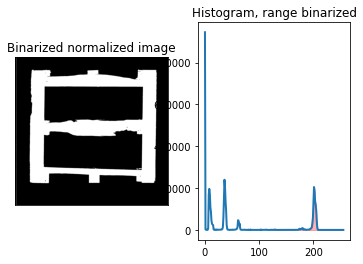

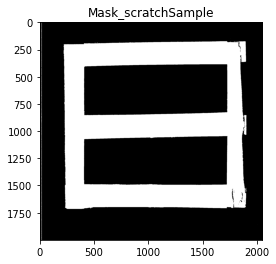

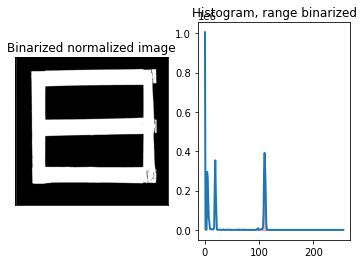

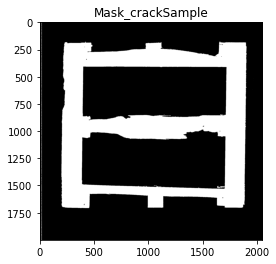

In [66]:


# will return 3 values indicating the depth of [bg, middleboards,topboards]
def getDepthLayersCenters(images, nof_clusters = 3):
    
    arr_ = []
    # cluster model
    
    scale_percent = 30
    #kmeans = blobs.KMeans(n_clusters=3, init='k-means++', random_state=0, max_iter=1)
    for ima in images:
        image8bNorm = Convert8bAndNormalize ( ima ) 
        width = int(image8bNorm.shape[1] * scale_percent / 100)
        height = int(image8bNorm.shape[0] * scale_percent / 100)
        dim = (width, height)
  
        # resize image to a 30% the original slcale
        resized = cv.resize(image8bNorm, dim)
        
        # validate not null - skipped
        arr_flatten = resized.flatten()
        kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0, max_iter=1)
        kmeans.fit(arr_flatten.reshape(-1,1)) 
        arr_.append(sorted(np.array(kmeans.cluster_centers_)))
            
    # convert from list to array    
    arr_ = np.array(arr_)
    
    nof_images = np.array(arr_).shape[0]
    nof_centers = np.array(arr_).shape[1]
    
    avr_centers = np.sum(arr_,axis=0)/nof_images

    # round and return
    return np.rint(sorted(avr_centers))


def median_value(val1, val2):
    threshold = np.rint((val1+val2)/2)
    threshold = int(threshold)
    return threshold

def getLayerByGreyRange(image, minTH, maxTH):
    
    #  th, im_th = cv.threshold(image, minTH, maxTH, cv.THRESH_BINARY)
    im_th = cv.inRange(image, minTH, maxTH)

    return im_th


def getHigherLayer(image8bNorm_, cluster_c, verbose_ = False):
    
    # top boards layer
    # threshold = th_value
    threshold = median_value(cluster_c[len(cluster_c)-2],cluster_c[len(cluster_c)-1])
    max_threshold = 255 # till whitest white

    hist_values_norm = cv.calcHist([image8bNorm_.flatten()],channels=[0],mask=None,histSize=[256],ranges=[0,255])    

    # Get binarized image of the layer
    imageTopTH = getLayerByGreyRange(image8bNorm_, threshold, max_threshold)

    if(verbose_):

        mySF.showRangeHist(imageTopTH,hist_values_norm,[threshold,256])


    return imageTopTH

###############     execution part      ############

# SELECT A CRACK AND A SCRATCH SAMPLE
scract_sample_filepath = area_B58_scratch[0]
crack_sample_filepath = area_B78_crack[0]

# GET CLUSTER LEVELS
calib_images =[scract_image16]
clusters_centers_scratch = getDepthLayersCenters(calib_images)
calib_images =[crack_image16]
clusters_centers_crack = getDepthLayersCenters(calib_images)

# This is a mask, i expect that at least scratches are included, otherwise we might have to use close/morphology operations
imageTopTH_scratch = getHigherLayer(scract_image8bNorm, clusters_centers_scratch,True)
imageTopTH_crack = getHigherLayer(crack_image8bNorm, clusters_centers_crack,True)

# close holes in the mask
imageTopTH_scratch = mySF.close(imageTopTH_scratch,3)
imageTopTH_crack = mySF.close(imageTopTH_crack,3)



mySF.showQuickImage(imageTopTH_scratch,"Mask_scratchSample")
mySF.showQuickImage(imageTopTH_crack,"Mask_crackSample")



##  

## Area Cutoff area:
Also, cutting the mask at the same position

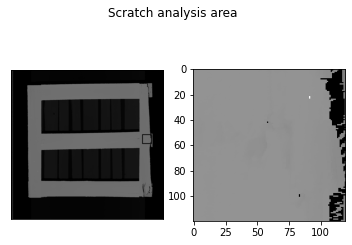

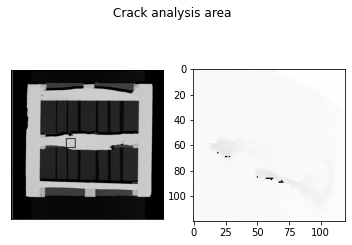

In [67]:
### Apply mast to cut off region
def applyMaskToImage(image,mask):
    copyImage = image.copy()
    if image.shape == mask.shape:
        for i  in range(mask.shape[0]):
            for j  in range(mask.shape[1]):
                if(not mask[i][j]):
                    copyImage[i][j] = 0
                    
        return copyImage
                
        # return cv.bitwise_and(image, mask)  # must then convert images to the same format (uint8 or 16)
    else: 
        print("Error: matrixes must be the same size.")
        return -1


distance = 60


# im leaving the printed


# mySF.show2ImagesSideBySide(rectangle_area_scratch,cutoff_scratch_mask,"Scratch analysis area")
# mySF.show2ImagesSideBySide(rectangle_area_crack,cutoff_crack_mask,"Crack analysis area")

marked_scratch = scract_image16.copy() 
marked_crack = crack_image16.copy() 
marked_scratch = cv.rectangle(marked_scratch, [scract_sample_location[0]-distance,scract_sample_location[1]-distance], [scract_sample_location[0]+distance,scract_sample_location[1]+distance], [150], 10)
marked_crack = cv.rectangle(marked_crack, [crack_sample_location[0]-distance,crack_sample_location[1]-distance], [crack_sample_location[0]+distance,crack_sample_location[1]+distance], [150], 10)

cutoff_scratch_mask = mySF.getImageCutoffAroundPoint(imageTopTH_scratch,scract_sample_location,distance)
cutoff_crack_mask = mySF.getImageCutoffAroundPoint(imageTopTH_crack,crack_sample_location,distance)

cutoff_scratch = mySF.getImageCutoffAroundPoint(scract_image16,scract_sample_location,distance)
cutoff_crack = mySF.getImageCutoffAroundPoint(crack_image16,crack_sample_location,distance)

# mySF.showQuickImage(cutoff_scratch_mask, "mask")
# mySF.showQuickImage(cutoff_crack_mask, "mask")

MaskApplied_scratch = applyMaskToImage(cutoff_scratch,cutoff_scratch_mask)
MaskApplied_crack = applyMaskToImage(cutoff_crack,cutoff_crack_mask)

mySF.show2ImagesSideBySide(marked_scratch,cutoff_scratch,"Scratch analysis area")
mySF.show2ImagesSideBySide(marked_crack,cutoff_crack,"Crack analysis area")





## Identify and split boards sections.
<a name ="split"></a>
I must mention that there are many, many ways to tackle this problem. We must first be aware of how many boards are we dealing with. We expect that we would be mostly getting 7 segments, however, we should be ready to deal with either 7 or 8. This would normally mean that the combined boards appear splitted.
It could also mean that a board was broken, in this kind of scenarios we should report an error.

<br>
Spaces should be consistent across the whole board, meaning that each should have a similar size. In any other scenario,




Testing >> finding scratches in scratch image...


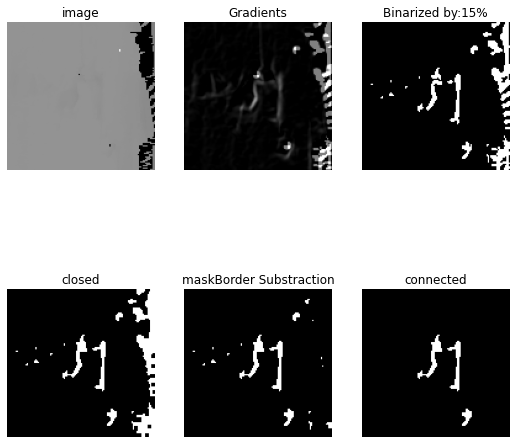

Detected :True
Testing >> finding scratches in crack image...


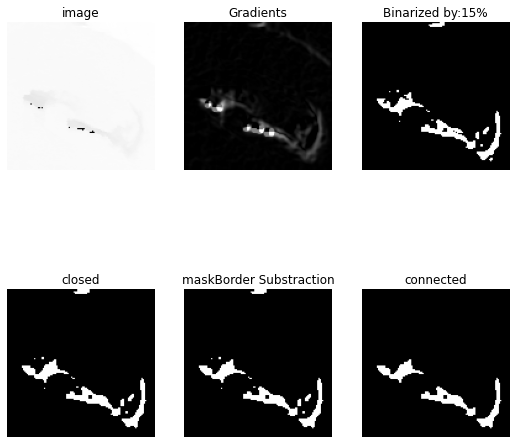

Detected :True
Testing >> finding cracks in crack image...


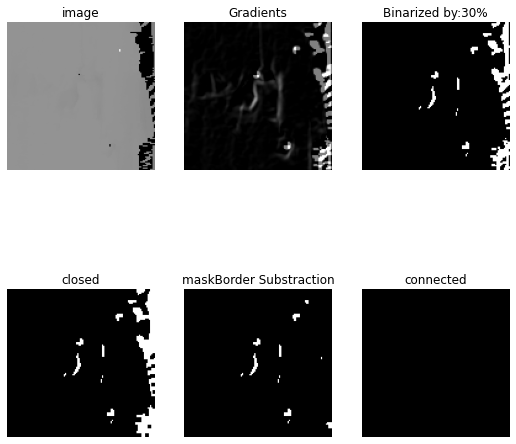

Detected :False
Testing >> finding cracks in crack image...


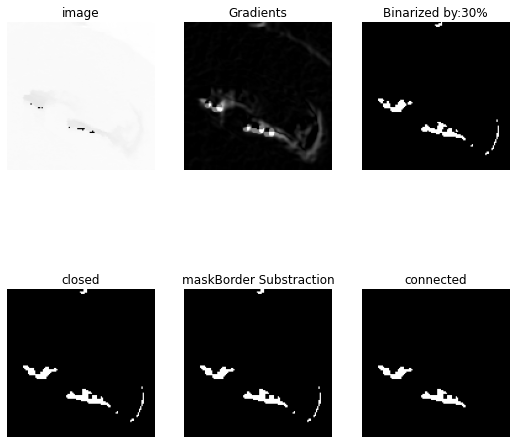

Detected :True


In [68]:


def Gradients(imageGrey,KSIZE):
    
  copyImg = imageGrey.copy()  
  copyImg = cv.GaussianBlur(copyImg, (KSIZE,KSIZE), cv.BORDER_DEFAULT )
  
  sobelx64 = cv.Sobel(imageGrey,cv.CV_16U,1,0,ksize=KSIZE)
  sobely64 = cv.Sobel(imageGrey,cv.CV_16U,0,1,ksize=KSIZE)
  combined = cv.addWeighted(sobelx64, 0.5, sobely64, 0.5, 0)
  return combined

def BinGrads(gradsImage, thPercent):
  copyImage = gradsImage.copy()
  max_val = gradsImage.max()
  # copyImage = np.zeros([gradsImage[0],gradsImage[1],cv.CV_16U])
  thvalue = thPercent*(max_val)/100
  for i  in range(gradsImage.shape[0]):
      for j  in range(gradsImage.shape[1]):
          if( abs(gradsImage[i][j]) > thvalue):
              copyImage[i][j] = 65535
          else :
            copyImage[i][j] = 0  
             
  return copyImage

def substractMask(image, mask,value):
    maskCopy = mask.copy()
    maskCopy = mySF.erode(maskCopy, value)
    maskCopy = applyMaskToImage(image,maskCopy)
    return maskCopy

def keepConnectedComponents(img, min_size, connectivity=8):
    
  found = False
  
    # Find all connected components (called here "labels")
  imgCopy = img.copy()
    # num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(
    #     img, connectivity=connectivity)
  num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(imgCopy,connectivity)
    
    # check size of all connected components (area in pixels)
  for i in range(num_labels):
        label_size = stats[i, cv.CC_STAT_AREA]
        
        # remove connected components smaller than min_size
        if label_size < min_size:
            imgCopy[labels == i] = 0
            num_labels-=1
    
    # 1 is the minimum value because the background counts
  if(num_labels > 1):
      found = True

          
  return imgCopy ,found


def DetectScratchesLevel(image, mask,verbose = False):
  bin_percent_th = 15
  grad = Gradients(image,7)
  bin = BinGrads(grad, bin_percent_th)
  
  close = mySF.close(bin,3)
  applyMask = substractMask(close, mask, 7)
  convert = Convert8b(applyMask)
  connected, check = keepConnectedComponents(convert, 50, connectivity=8)
  
  
  if verbose:
    fig = plt.figure(figsize=(9, 9))  
    # ax.set_xlabel("Check Scratches")
    fig.add_subplot(2, 3, 1)
    # showing image
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.title("image")
    
    fig.add_subplot(2, 3, 2)
    # showing image
    plt.imshow(grad,cmap='gray')
    plt.axis('off')
    plt.title("Gradients")
    
    fig.add_subplot(2, 3, 3)
    # showing image
    plt.imshow(bin,cmap='gray')
    plt.axis('off')
    plt.title("Binarized by:" +str(bin_percent_th)+ "%")
    
    fig.add_subplot(2, 3, 4)
    # showing image
    plt.imshow(close,cmap='gray')
    plt.axis('off')
    plt.title("closed")
    
    fig.add_subplot(2, 3, 5)
    # showing image
    plt.imshow(convert,cmap='gray')
    plt.axis('off')
    plt.title("maskBorder Substraction")
    
    fig.add_subplot(2, 3, 6)
    # showing image
    plt.imshow(connected,cmap='gray')
    plt.axis('off')
    plt.title("connected")
      

    plt.show()
  
  return connected, check

def DetectCracksLevel(image, mask,verbose = False):
  bin_percent_th = 30
  grad = Gradients(image,7)
  bin = BinGrads(grad,bin_percent_th )
  
  close = mySF.close(bin,3)
  applyMask = substractMask(close, mask, 7)
  convert = Convert8b(applyMask)
  connected, check = keepConnectedComponents(convert, 50, connectivity=8)
  
  if verbose:
        

    fig = plt.figure(figsize=(9, 9))  
    # ax.set_xlabel("Check Cracks")
    fig.add_subplot(2, 3, 1)
    # showing image
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.title("image")
    
    fig.add_subplot(2, 3, 2)
    # showing image
    plt.imshow(grad,cmap='gray')
    plt.axis('off')
    plt.title("Gradients")
    
    fig.add_subplot(2, 3, 3)
    # showing image
    plt.imshow(bin,cmap='gray')
    plt.axis('off')
    plt.title("Binarized by:" +str(bin_percent_th)+ "%")
    
    fig.add_subplot(2, 3, 4)
    # showing image
    plt.imshow(close,cmap='gray')
    plt.axis('off')
    plt.title("closed")
    
    fig.add_subplot(2, 3, 5)
    # showing image
    plt.imshow(convert,cmap='gray')
    plt.axis('off')
    plt.title("maskBorder Substraction")
    
    fig.add_subplot(2, 3, 6)
    # showing image
    plt.imshow(connected,cmap='gray')
    plt.axis('off')
    plt.title("connected")
      

    plt.show()
          
  return connected, check





############  Execurtion ##################

# gradients_scratch = Gradients(MaskApplied_scratch,7)
# gradients_crack = Gradients(MaskApplied_crack,7)


# mgBw_crack = BinGrads(gradients_crack, 15)

print("Testing >> finding scratches in scratch image..." )
FINAL_1, found = DetectScratchesLevel(MaskApplied_scratch,cutoff_scratch_mask,True)
print("Detected :"+ str(found) )
print("Testing >> finding scratches in crack image..." )
FINAL_2, found = DetectScratchesLevel(MaskApplied_crack,cutoff_crack_mask,True)
print("Detected :"+ str(found) )
print("Testing >> finding cracks in crack image..." )
FINAL_1, found = DetectCracksLevel(MaskApplied_scratch,cutoff_scratch_mask,True)
print("Detected :"+ str(found) )
print("Testing >> finding cracks in crack image..." )
FINAL_2, found = DetectCracksLevel(MaskApplied_crack,cutoff_crack_mask,True)
print("Detected :"+ str(found) )




## Remove 
<a name ="Remove"></a>



C
Boards expected to ocuppy the following space in the image: 
[[193, 402], [403, 528], [550, 725], [757, 919], [934, 1165], [1176, 1341], [1364, 1527], [1531, 1667], [1668, 1892]]


## UNIT TEST 

Ahead there is a unit that will run every image in the Test list.

I will normally build a binary executable, but currently I have not set up a way to read or input where the scract coordinates are located. Therefore this is the only way of testing.

In [69]:
# we will load 

VERBOSE_ = False  # enable if want to observe 

# raining_scratch_list = [area_D59_scratch]
# training_crack_list = [area_B78_crack,area_D82_crack,area_E24_crack]
# # image + labels,... there is an issue here, not knowing which is which in case of crack and scratches in the same board
# test_list = [[area_D83_crack,[crack_label]],[area_E56_crack,[crack_label]],[area_E70_crack,[crack_label]],[area_B58_scratch,[scratch_label]]]
# area_D59_scratch = [BOTTOM_IMAGES_PATH+"B59.tif",[[1078,440], [1037,1088], [1000,1622]] ]


# multiAreaList = [area_D59_scratch,area_B78_crack]
# test_list = [area_D83_crack,area_E56_crack,area_E70_crack,area_B58_scratch]

# Globals
th_scratch = 15 
th_dmg = 30
distance = 60


def runList(_list):
# for each element in the list 
    for elem in _list:
        
        image_path = elem[0]
        checking_areas = elem[1]
        
        img = cv.imread(image_path, -1)
        image8bNorm = Convert8bAndNormalize ( img )
        # prepare mask
        clusters_centers = getDepthLayersCenters([img])   # param is a list, we took the function from the other project
        top_mask = getHigherLayer(image8bNorm, clusters_centers,VERBOSE_)
        top_mask = mySF.close(top_mask,25)

        for area in checking_areas:
            # get the areas
            # area 
            cutoff_mask = mySF.getImageCutoffAroundPoint(img,area,distance)
            cutoff_img = mySF.getImageCutoffAroundPoint(top_mask,area,distance)
            MaskApplied = applyMaskToImage(cutoff_img,cutoff_mask)
            
            damaged = False
            segmented, check = DetectScratchesLevel(MaskApplied,cutoff_mask ,VERBOSE_)
            
            if(check):
                segmented, check = DetectCracksLevel(MaskApplied,cutoff_mask ,VERBOSE_)
                # if there is a scratch, there might be a Crack
                if(check):
                    damaged = True
            
            
            # TODO 
            # ADD RECTANGLE COLORED - IF DAMAGED OR NOT
            # DISPLAY SEGMENTED ON THE SIDE
            
            # convert image to color and print rectangle on area based on 
        
        
    #######     EXECUTION   #######            
runList(test_list)

    
    
